In [73]:
import copy

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#计算特征值模块
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# 机器学习模块
from sklearn import model_selection
from sklearn.linear_model import Lasso,LassoCV
from sklearn.metrics import mean_squared_error

# 随机森林模块
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#套用网站的九种理化性质计算出来，将序列分成三段，计算相关性，使用lasso进行回归预测，使用随机森林进行预测
#计算靠近的四个端点的理化性质

In [74]:
os.chdir(r'E:\文件\大学课程\大四上\毕业设计\数据分析\ninthweek')
df=pd.read_excel('all-peptides-pairs.xlsx',header=0)
#筛选出第一种分类拿来做实验
# testdf=df[(df['stick_terminal']=='n_terminal') & (df['communal-modification']=='none') & (df['modification2']=='AMD')]
# testdf=df[(df['modification2'].isin(['C3', 'C4', 'C5','C6','C7','C8','C10','C11','C12','C13','C14','C15','C16','C18','C19','C20'])) & (df['communal-modification']=='none') & (df['stick_terminal']=='c_terminal')].copy()
testdf=df[(df['modification2'].isin(['C3', 'C4', 'C5','C6','C7','C8','C10','C11','C12','C13','C14','C15','C16','C18','C19','C20'])) & (df['communal-modification']=='AMD') & (df['stick_terminal']=='c_terminal')].copy()
testdf = testdf[~testdf['sequence'].str.contains('[a-z]')]      #把构象不同的氨基酸筛掉
testdf = testdf[~testdf['sequence'].str.contains('X')]          #把非常规氨基酸筛掉
df_filtered = testdf[testdf['sequence'].str.len() >= 6]          #保证序列长度大于等于4
df_filtered=df_filtered[df_filtered['fold-change']!=0]
# df_filtered.to_excel('df_filtered.xlsx',index=False)

In [75]:
df_filtered

,sequence,target,stick_terminal,communal-modification,measure,unit,modification1,modification2,activity1,activity2,fold-change,abs(none-modification)
3788,ALWKTLLKKVLKA,Staphylococcus aureus B38302,c_terminal,AMD,MIC,uM,none,C16,9.0,50.0,-2.473931,41.0
3789,ALWKTLLKKVLKA,Escherichia coli U16318,c_terminal,AMD,MIC,uM,none,C16,4.5,50.0,-3.473931,45.5
3790,WKLFKKILKVL,Erwinia amylovora PMV 6076,c_terminal,AMD,MIC,uM,none,C16,8.5,75.0,-3.141356,66.5
3791,WKLFKKILKVL,Pseudomonas syringae EPS 94,c_terminal,AMD,MIC,uM,none,C16,8.5,75.0,-3.141356,66.5
3792,WKLFKKILKVL,Xanthomonas vesicatoria 2133-2,c_terminal,AMD,MIC,uM,none,C16,8.5,37.5,-2.141356,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5788,KWKLFKKIGAVLKVL,Escherichia coli ML-35,c_terminal,AMD,LD50,uM,none,C14,1.4,1.3,0.106915,0.1
5789,KWKLFKKIGAVLKVL,Leishmania sp. (promastigote),c_terminal,AMD,LD50,uM,none,C16,4.4,1.2,1.874469,3.2
5790,KWKLFKKIGAVLKVL,Leishmania sp. (amastigote),c_terminal,AMD,LD50,uM,none,C16,14.4,3.9,1.884523,10.5
5791,KWKLFKKIGAVLKVL,Micrococcus luteus ATCC 15307,c_terminal,AMD,LD50,uM,none,C16,0.8,2.9,-1.857981,2.1


In [76]:
df_filtered[df_filtered['fold-change']!=0]

,sequence,target,stick_terminal,communal-modification,measure,unit,modification1,modification2,activity1,activity2,fold-change,abs(none-modification)
3788,ALWKTLLKKVLKA,Staphylococcus aureus B38302,c_terminal,AMD,MIC,uM,none,C16,9.0,50.0,-2.473931,41.0
3789,ALWKTLLKKVLKA,Escherichia coli U16318,c_terminal,AMD,MIC,uM,none,C16,4.5,50.0,-3.473931,45.5
3790,WKLFKKILKVL,Erwinia amylovora PMV 6076,c_terminal,AMD,MIC,uM,none,C16,8.5,75.0,-3.141356,66.5
3791,WKLFKKILKVL,Pseudomonas syringae EPS 94,c_terminal,AMD,MIC,uM,none,C16,8.5,75.0,-3.141356,66.5
3792,WKLFKKILKVL,Xanthomonas vesicatoria 2133-2,c_terminal,AMD,MIC,uM,none,C16,8.5,37.5,-2.141356,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5788,KWKLFKKIGAVLKVL,Escherichia coli ML-35,c_terminal,AMD,LD50,uM,none,C14,1.4,1.3,0.106915,0.1
5789,KWKLFKKIGAVLKVL,Leishmania sp. (promastigote),c_terminal,AMD,LD50,uM,none,C16,4.4,1.2,1.874469,3.2
5790,KWKLFKKIGAVLKVL,Leishmania sp. (amastigote),c_terminal,AMD,LD50,uM,none,C16,14.4,3.9,1.884523,10.5
5791,KWKLFKKIGAVLKVL,Micrococcus luteus ATCC 15307,c_terminal,AMD,LD50,uM,none,C16,0.8,2.9,-1.857981,2.1


In [77]:
def Hydrophobicity(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='full':
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        gravy_score = protein.gravy()
        return gravy_score
def PI(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='full':
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        isoelectric_point = protein.isoelectric_point()
        return isoelectric_point
def Charge(seq,index):
    single=['1','2','0','-1','-2','-3']
    if index in single:
        new_index=int(index)
        protein = ProteinAnalysis(seq[new_index])
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='full':
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='start':
        length=len(seq)//3
        seq=seq[:length]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='end':
        length=len(seq)//3
        seq=seq[-length:]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge
    elif index=='middle':
        length=len(seq)//3
        seq=seq[length:-length]
        protein = ProteinAnalysis(seq)
        charge = protein.charge_at_pH(7)
        return charge

In [78]:
# 计算30个特征
df_attributes=pd.DataFrame()
P_list=['Charge','Hydrophobicity','PI']
types=['0','1','2','-1','-2','-3','full','start','middle','end']
# a_list
for i in types:
    for j in P_list:
        colname='&'.join([i,j])
        if j=='Charge':
            df_attributes[colname]=df_filtered['sequence'].apply(Charge,args=(i,))
        elif j=='Hydrophobicity':
            df_attributes[colname]=df_filtered['sequence'].apply(Hydrophobicity,args=(i,))
        else:
            df_attributes[colname]=df_filtered['sequence'].apply(PI,args=(i,))

In [79]:
#把特征和变量放入一个文件
all_df=copy.deepcopy(df_attributes)
all_df['fold-change']=copy.deepcopy(df_filtered['fold-change'])
all_df

,0&Charge,0&Hydrophobicity,0&PI,1&Charge,1&Hydrophobicity,1&PI,2&Charge,2&Hydrophobicity,2&PI,-1&Charge,...,start&Charge,start&Hydrophobicity,start&PI,middle&Charge,middle&Hydrophobicity,middle&PI,end&Charge,end&Hydrophobicity,end&PI,fold-change
3788,-0.204125,1.8,5.570017,-0.239898,3.8,5.525000,-0.239898,-0.9,5.525000,-0.204125,...,0.794876,0.200000,8.795051,1.396199,-0.18,10.000545,0.732989,1.475000,8.720010,-2.473931
3789,-0.204125,1.8,5.570017,-0.239898,3.8,5.525000,-0.239898,-0.9,5.525000,-0.204125,...,0.794876,0.200000,8.795051,1.396199,-0.18,10.000545,0.732989,1.475000,8.720010,-3.473931
3790,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,0.759103,-0.333333,8.750052,1.758104,0.66,10.002737,0.759103,1.366667,8.750052,-3.141356
3791,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,0.759103,-0.333333,8.750052,1.758104,0.66,10.002737,0.759103,1.366667,8.750052,-3.141356
3792,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.239898,3.8,5.525000,-0.239898,...,0.759103,-0.333333,8.750052,1.758104,0.66,10.002737,0.759103,1.366667,8.750052,-2.141356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5788,0.759103,-3.9,8.750052,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.239898,...,1.758104,-0.420000,10.002737,1.758104,-0.38,10.002737,0.732989,2.420000,8.720010,0.106915
5789,0.759103,-3.9,8.750052,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.239898,...,1.758104,-0.420000,10.002737,1.758104,-0.38,10.002737,0.732989,2.420000,8.720010,1.874469
5790,0.759103,-3.9,8.750052,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.239898,...,1.758104,-0.420000,10.002737,1.758104,-0.38,10.002737,0.732989,2.420000,8.720010,1.884523
5791,0.759103,-3.9,8.750052,-0.239898,-0.9,5.525000,0.759103,-3.9,8.750052,-0.239898,...,1.758104,-0.420000,10.002737,1.758104,-0.38,10.002737,0.732989,2.420000,8.720010,-1.857981


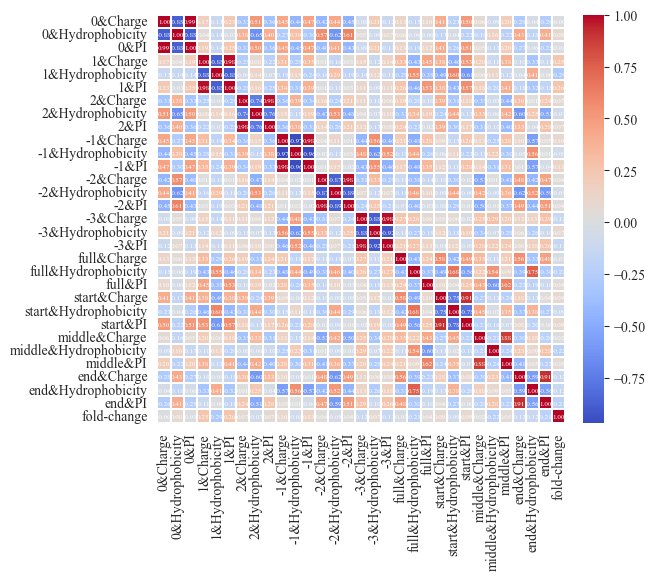

In [80]:
# 计算相关性并绘制相关性热图
corr_data=all_df.corr(method='pearson')
#绘制相关性热图
plt.figure(figsize=(8,6), facecolor='w') # 底色white
cor_map = sns.heatmap(corr_data, square=True, annot=True, fmt='.2f',
                 linewidth=0.1, cmap='coolwarm',linecolor='white', cbar=True,
                 annot_kws={'size':5,'weight':'normal','color':'white'},
                 cbar_kws={'fraction':0.046, 'pad':0.03})
plt.rcParams['font.sans-serif']= ['Times New Roman']    # 设置字体
# plt.xticks(rotation=90,fontsize=8)  # x轴的标签旋转90度
# plt.yticks(fontsize=8)
plt.subplots_adjust(bottom=0.2,left=0.05,right=0.8)
plt.savefig("A-C-2_heatmap.png", dpi=1300)

In [87]:

# 使用lasso直接进行建模
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 读取数据
lasso_model = copy.deepcopy(all_df)  #原始文件改变需要调这里，切记这个原始文件是所有特征和fold-change合在一起了

# 分离特征和因变量
X_lasso = lasso_model.drop('fold-change', axis=1)
y_lasso = lasso_model['fold-change']

# 数据标准化
scaler = StandardScaler()
X_lasso = scaler.fit_transform(X_lasso)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y_lasso, test_size=0.1, random_state=42)

# Lasso模型训练
lasso = Lasso()
param_grid = {'alpha': [0.00001,0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]}
grid_search = GridSearchCV(lasso, param_grid=param_grid, cv=8)
grid_search.fit(X_train, y_train)

# 最佳alpha值
best_alpha = grid_search.best_params_['alpha']

# 选择重要特征
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)
coef = pd.Series(lasso.coef_, index=all_df.columns[:-1])  #原始文件改变需要调这里
important_features = coef.abs().nlargest(5).index.tolist()

# 模型评估
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('R2:', r2)

D:\办公软件\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.777e+02, tolerance: 2.693e-01
  model = cd_fast.enet_coordinate_descent(
D:\办公软件\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.766e+02, tolerance: 2.647e-01
  model = cd_fast.enet_coordinate_descent(
D:\办公软件\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.706e+02, tolerance: 2.649e-01
  model = cd_fast

MSE: 2.9530127023343304
R2: 0.3686477043507138


D:\办公软件\python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.343e+02, tolerance: 3.071e-01
  model = cd_fast.enet_coordinate_descent(


In [82]:
# 输出所有特征的系数
# 输出所有特征的系数
sorted_index = coef.abs().argsort()[::-1]
sorted_s = coef.iloc[sorted_index]
sorted_s.to_excel(r'A-C-2-coef2.xlsx')   #输出具有0的样本

In [88]:
# # 根据lasso提取系数较高的特征和变量重建一个文档
# newcolumns=['start&Charge','middle&Charge','start&Hydrophobicity','middle&Hydrophobicity','end&Charge','3&PI','full&Hydrophobicity','full&Charge','fold-change']
# new_all_data=all_df[newcolumns]
# new_all_data
best_alpha

0.0001

In [84]:
# 随机森林模型
# 将y变为离散型
model_data=copy.deepcopy(all_df)
model_data['sig']=0
model_data.loc[model_data['fold-change']>0,'sig']=1
model_data.loc[model_data['fold-change']<0,'sig']=-1

# 拆分自变量和变量
X=copy.deepcopy(model_data.drop('fold-change',axis=1))
X=X.drop('sig',axis=1)
y=copy.deepcopy(model_data['sig'])



# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# 构建随机森林模型
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10, random_state=123,bootstrap=True)

# 在训练集上训练模型
rfc.fit(X_train, y_train)

# 在测试集上测试模型性能
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# 在训练集上训练模型
rfc.fit(X_train, y_train)

# 在测试集上测试模型性能
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# 输出模型评估结果
print("Accuracy:", accuracy)

# 输出评价参数
print(classification_report(y_test, y_pred))
# print(classification_report((y_train,)))

Accuracy: 0.8412698412698413
              precision    recall  f1-score   support

          -1       0.60      0.69      0.64        13
           1       0.92      0.88      0.90        50

    accuracy                           0.84        63
   macro avg       0.76      0.79      0.77        63
weighted avg       0.85      0.84      0.85        63



In [85]:
# 提取特征重要性
importances = rfc.feature_importances_
indices = importances.argsort()[::-1]
for i in indices:
    print(f"{X.columns[i]}: {importances[i]}")

full&Hydrophobicity: 0.11415234519140065
end&PI: 0.07209876988152147
-3&Hydrophobicity: 0.061255728949860935
full&Charge: 0.05543491257975937
end&Hydrophobicity: 0.053465430100403326
end&Charge: 0.05130997123425995
start&Hydrophobicity: 0.0506191648634562
full&PI: 0.049327013188932886
start&Charge: 0.045999648813561285
start&PI: 0.04389400253712369
0&Hydrophobicity: 0.03982311303854489
middle&PI: 0.039077364595180145
middle&Charge: 0.03860682595869386
middle&Hydrophobicity: 0.03782003547628409
1&Hydrophobicity: 0.03463283289862877
1&PI: 0.02723941661753089
-3&Charge: 0.025652133977715305
1&Charge: 0.025533408842481276
-2&PI: 0.016726930778389094
-3&PI: 0.016338088288350452
-2&Charge: 0.015212082097079778
-2&Hydrophobicity: 0.014838604687328154
0&Charge: 0.014523715545883442
2&Hydrophobicity: 0.012958828077178186
0&PI: 0.012395501168825946
-1&Hydrophobicity: 0.007803831796902745
2&Charge: 0.0071665900194627956
2&PI: 0.006489105072606733
-1&Charge: 0.006453783104180909
-1&PI: 0.003150820